# **BiLSTM**

In [1]:
!pip install tensorflow==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 37.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing 

In [2]:
!wget https://raw.githubusercontent.com/Topaz52/phishing-website-URL-dataset/main/cleaned_rnn_phishtank_sampled%3D19300.csv
!wget https://raw.githubusercontent.com/Topaz52/phishing-website-URL-dataset/main/cleaned_rnn_zenodo_sampled%3D19300.csv

--2024-01-17 05:46:55--  https://raw.githubusercontent.com/Topaz52/phishing-website-URL-dataset/main/cleaned_rnn_phishtank_sampled%3D19300.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2373284 (2.3M) [text/plain]
Saving to: ‘cleaned_rnn_phishtank_sampled=19300.csv’

cleaned_rnn_phishta 100%[===================>]   2.26M  10.3MB/s    in 0.2s    

2024-01-17 05:46:55 (10.3 MB/s) - ‘cleaned_rnn_phishtank_sampled=19300.csv’ saved [2373284/2373284]

--2024-01-17 05:46:55--  https://raw.githubusercontent.com/Topaz52/phishing-website-URL-dataset/main/cleaned_rnn_zenodo_sampled%3D19300.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.github

In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from prettytable import PrettyTable
import tensorflow as tf

In [4]:
print(tf.__version__)

2.8.0


In [5]:
# Some high level parameters:
show_top_n = 20
random_seed = 16

# Setting the random seed so that the code is repeatable.
np.random.seed(random_seed)

In [6]:
phishtank_dataset_drop_df_without_intersection = pd.read_csv("cleaned_rnn_phishtank_sampled=19300.csv")
zenodo_dataset_df_without_intersection = pd.read_csv("cleaned_rnn_zenodo_sampled=19300.csv")

In [7]:
# Set oversampling_rate to 1 to have the positive samples match the phishing samples. Set to greater than 1 to use more negative samples.
oversampling_rate = 1.5

# Getting the array of all phishing domain names.
phishing_domains = phishtank_dataset_drop_df_without_intersection["domain_names"].values
# Randomly sample a number of safe urls, sice the ratio of classes in the training data should not be too much out of balance.
whitelist_domains = np.random.choice(zenodo_dataset_df_without_intersection["domain_names"].values, size=int(oversampling_rate*len(phishing_domains)), replace=True)

In [8]:
print("Selected Data Examples:")
print("Phishing domains:", phishing_domains, len(phishing_domains))
print("Benign domains:", whitelist_domains, len(whitelist_domains))

Selected Data Examples:
Phishing domains: ['informaciondaviplata.daviplataing.repl.co' 'connect-bored-ape.net'
 'bestchangetest1.zzz.com.ua' ... 'tnrgbjfrha.van4fsrch.club'
 'crownchicrop.com' 'infura-ipfs.io'] 19300
Benign domains: ['en.wikipedia.org' 'homepages.rootsweb.ancestry.com' 'taactivities.org'
 ... 'en.wikipedia.org' 'articles.sfgate.com' 'qvedtech.blogspot.com'] 28950


In [9]:
# Calling a phishing url 1 and a not-phishing url 0.
# Using character encoding as the vocabulary.
# Feeding the url as the sequence.
# Creating the samples array and the label array
print()
X = list(phishing_domains) + list(whitelist_domains)
y = [1]*len(phishing_domains) + [0]*len(whitelist_domains)
sample_weights = [1]*len(phishing_domains) + [1/oversampling_rate]*len(whitelist_domains)

In [10]:
# Encoding code/idea from TensorFlow 2.0 Complete Course - Python Neural Networks for Beginners Tutorial freeCodeCamp.org
# https://colab.research.google.com/drive/1ysEKrw_LE2jMndo1snrZUh5w87LQsCxk#forceEdit=true&sandboxMode=true
vocab = sorted(set("".join(X)), reverse=True)
# Inserting a space at index 0, since it is not used in url and will be used for padding the examples.
vocab.insert(0, " ")
vocab_size = len(vocab)

print()
print(f"Encoding Vocabulary ({vocab_size}) used:")
print(vocab)
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

def text_to_int(text):
  return np.array([char2idx[c] for c in text])

print("Encoding example:")
print(text_to_int(phishing_domains[0]))

def int_to_text(ints):
  try:
    ints = ints.numpy()
  except:
    pass
  return ''.join(idx2char[ints])

print(int_to_text(text_to_int(phishing_domains[0])))


Encoding Vocabulary (81) used:
[' ', 'я', 'ъ', 'у', 'с', 'р', 'н', 'м', 'и', 'е', 'д', 'а', 'z', 'y', 'x', 'w', 'v', 'u', 't', 's', 'r', 'q', 'p', 'o', 'n', 'm', 'l', 'k', 'j', 'i', 'h', 'g', 'f', 'e', 'd', 'c', 'b', 'a', '_', 'Z', 'Y', 'X', 'W', 'V', 'U', 'T', 'S', 'R', 'Q', 'P', 'O', 'N', 'M', 'L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A', '@', '?', '=', ':', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0', '.', '-']
Encoding example:
[29 24 32 23 20 25 37 35 29 23 24 34 37 16 29 22 26 37 18 37 79 34 37 16
 29 22 26 37 18 37 29 24 31 79 20 33 22 26 79 35 23]
informaciondaviplata.daviplataing.repl.co


In [11]:
# Investigating the domain name length for the combined domain names:
X_elem_len = [len(domain_name) for domain_name in X]
print(sorted(X_elem_len, reverse=True)[:show_top_n])

[102, 101, 97, 94, 91, 91, 90, 88, 86, 86, 85, 85, 85, 85, 85, 85, 85, 84, 84, 84]


In [12]:
# Setting some max length for our urls.
max_seq_len = 40
print((np.array(X_elem_len) > max_seq_len).sum(), "URLs longer than the cutoff length", max_seq_len)

2818 URLs longer than the cutoff length 40


In [13]:
X_train, X_test, y_train, y_test, sample_weights_train, sample_weights_test = train_test_split(np.array(X),
                                                                                               np.array(y),
                                                                                               np.array(sample_weights),
                                                                                               test_size=0.2,
                                                                                               random_state=random_seed)

In [14]:
X_train.shape, X_test.shape

((38600,), (9650,))

In [15]:
# Reducing how many samples to print so printouts dont get so big.
show_top_n = 5
print(f"Training and testing data: (showing first {show_top_n})")
print(f"Train data {len(X_train)} samples")
print(list(zip(X_train[:show_top_n], y_train[:show_top_n], sample_weights_train[:show_top_n])))
print(f"Test data {len(X_test)} samples")
print(list(zip(X_test[:show_top_n], y_test[:show_top_n], sample_weights_test[:show_top_n])))

Training and testing data: (showing first 5)
Train data 38600 samples
[('inpost-pl.wedtm.online', 1, 1.0), ('lyrics.wikia.com', 0, 0.6666666666666666), ('cpcskinhair.com', 1, 1.0), ('wiki.answers.com', 0, 0.6666666666666666), ('article.wn.com', 0, 0.6666666666666666)]
Test data 9650 samples
[('vanillacherryice.wordpress.com', 0, 0.6666666666666666), ('0xprotocol-stake.com', 1, 1.0), ('upcoming.yahoo.com', 0, 0.6666666666666666), ('docs.google.com', 1, 1.0), ('web.53educationlending.com', 0, 0.6666666666666666)]


In [16]:
# Encoding the domain names using the vocabulary
X_train_encoded = [text_to_int(domain_name) for domain_name in X_train]
X_test_encoded = [text_to_int(domain_name) for domain_name in X_test]
print()
print(f"Encoded data: (showing first {show_top_n})")
print(f"Train data {len(X_train_encoded)} samples, encoded")
print(list(zip(X_train_encoded[:show_top_n], y_train[:show_top_n])))
print(f"Test data {len(X_test_encoded)} samples, encoded")
print(list(zip(X_test_encoded[:show_top_n], y_test[:show_top_n])))

# Padding to the right sequence length.
X_train_encoded_padded = sequence.pad_sequences(X_train_encoded, max_seq_len)
X_test_encoded_padded = sequence.pad_sequences(X_test_encoded, max_seq_len)
print()
print(f"Encoded and padded data: (showing first {show_top_n})")
print(f"Train data {len(X_train_encoded_padded)} samples, encoded")
print(list(zip(X_train_encoded_padded[:show_top_n], y_train[:show_top_n])))
print(f"Test data {len(X_test_encoded_padded)} samples, encoded")
print(list(zip(X_test_encoded_padded[:show_top_n], y_test[:show_top_n])))


Encoded data: (showing first 5)
Train data 38600 samples, encoded
[(array([29, 24, 22, 23, 19, 18, 80, 22, 26, 79, 15, 33, 34, 18, 25, 79, 23,
       24, 26, 29, 24, 33]), 1), (array([26, 13, 20, 29, 35, 19, 79, 15, 29, 27, 29, 37, 79, 35, 23, 25]), 0), (array([35, 22, 35, 19, 27, 29, 24, 30, 37, 29, 20, 79, 35, 23, 25]), 1), (array([15, 29, 27, 29, 79, 37, 24, 19, 15, 33, 20, 19, 79, 35, 23, 25]), 0), (array([37, 20, 18, 29, 35, 26, 33, 79, 15, 24, 79, 35, 23, 25]), 0)]
Test data 9650 samples, encoded
[(array([16, 37, 24, 29, 26, 26, 37, 35, 30, 33, 20, 20, 13, 29, 35, 33, 79,
       15, 23, 20, 34, 22, 20, 33, 19, 19, 79, 35, 23, 25]), 0), (array([78, 14, 22, 20, 23, 18, 23, 35, 23, 26, 80, 19, 18, 37, 27, 33, 79,
       35, 23, 25]), 1), (array([17, 22, 35, 23, 25, 29, 24, 31, 79, 13, 37, 30, 23, 23, 79, 35, 23,
       25]), 0), (array([34, 23, 35, 19, 79, 31, 23, 23, 31, 26, 33, 79, 35, 23, 25]), 1), (array([15, 33, 36, 79, 73, 75, 33, 34, 17, 35, 37, 18, 29, 23, 24, 26, 33,
     

In [17]:
def evaluate_nn_model(X, y, threshold=0.5, bins=5, graph_bins=15, examples_per_bin=15):
    """
    Custom nn evaluation to get the TP, TN, FP, FN rates.
    Anything below threshold is considered not phishing.
    Anything above threshold is considered phishing.
    """
    predictions = model.predict(X).flatten()
    mean_prediction = np.mean(predictions)
    print(f"Calculated {len(predictions)} predictions with a mean value of {mean_prediction}")
    print(f"Evaluating using threshold {threshold}")
    # Turning the predictions into 0 and 1 by checking the threshold. (0 safe, 1 phishing)
    predictions_boolean = predictions > threshold
    predictions_binary = predictions_boolean.astype(np.int)
    print(f"Cut-off threshold: {np.round(threshold, decimals=4)}")
    groundtruth_elements, groundtruth_counts = np.unique(y, return_counts=True)
    groundtruth_counts = dict(zip(groundtruth_elements, groundtruth_counts))
    evaluation_ratios_counts, sample_outcomes = statistics_evaluator(predictions_binary, y)
    statistics_table_printer(evaluation_ratios_counts)
    # showing some examples for each type of outcome: 0 TN, 1 FP, 2 FN, 3 TP
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    outcome_index = [0, 1, 2, 3]
    outcome_plot_positions = [0, 1, 2, 3]
    outcome_labels = ["TN", "FP", "FN", "TP"]
    y_axis_max = 0
    for outcome in outcome_index:
        outcome_indexes = np.where(np.array(sample_outcomes) == outcome)[0]
        # Instead of random samples, do a histogram with bins of the predictions for this outcome.
        # Then sample examples from each bin.
        outcome_predictions = predictions[outcome_indexes]
        outcome_binary = [ int(ind) for ind in list(str(bin(outcome_plot_positions[outcome])).replace("0b","").rjust(2, "0"))]
        outcome_hist, outcome_bins = np.histogram(outcome_predictions, bins=bins)
        plot_hist, plot_bins = np.histogram(outcome_predictions, bins=graph_bins)
        outcome_total_count = groundtruth_counts[outcome_binary[0]]
        plot_hist = (100*np.array(plot_hist))/outcome_total_count
        axs[outcome_binary[0], outcome_binary[1]].bar(plot_bins[:-1], plot_hist, width = plot_bins[1]-plot_bins[0], align="edge")
        y_axis_max = max( max(plot_hist), y_axis_max)
        axs[outcome_binary[0], outcome_binary[1]].set_title(outcome_labels[outcome])
        # Randomly sample some examples from each bin for this outcome:
        for bin_start, bin_end in zip(outcome_bins[:-1], outcome_bins[1:]):
            bin_outcome_indexes = np.where( np.logical_and( np.array(outcome_predictions) >= bin_start, np.array(outcome_predictions) < bin_end ))[0]
            bin_outcome_indexes = outcome_indexes[bin_outcome_indexes]
            if len(bin_outcome_indexes) > examples_per_bin:
                chosen_bin_outcome_examples = np.random.choice(bin_outcome_indexes, size=examples_per_bin, replace=False)
            else:
                chosen_bin_outcome_examples = bin_outcome_indexes
            example_truth = y[chosen_bin_outcome_examples]
            example_input_encoded = X[chosen_bin_outcome_examples]
            example_input_decoded = [ int_to_text(example).strip() for example in example_input_encoded]
            example_prediction = predictions[chosen_bin_outcome_examples]
            example_df = pd.DataFrame(data={"input": example_input_decoded, "ground truth": example_truth, "prediction": example_prediction})
            print("\nExamples for", outcome_labels[outcome], "Bin range:", bin_start, "-", bin_end, ", Num. Samples:", len(bin_outcome_indexes))
            print(example_df.to_string())
    for ax in axs.flat:
        ax.set(xlabel='Prediction', ylabel='Percentage of samples')
        ax.set_ylim(0, y_axis_max*1.02)
        ax.grid()
    plt.tight_layout()
    fig.savefig('outcome_distributions_reduced.pdf')
    return mean_prediction

def statistics_evaluator(predictions_binary, y_binary):
    # Concattenating the strings of the binary value of the prediction and the truth.
    # First value is the prediction, second the actual label
    # Hypothesis is: is phishing -> positive: yes phishing, negative: no phishing
    # Then 00 would be a TN, 01 is a FP, 10 is a FN, 11 is a TP.
    # Converting the binary outcomes to integer: 0 TN, 1 FP, 2 FN, 3 TP
    hypothesis_tests = [int(str(label)+str(prediction), 2) for prediction, label in zip(predictions_binary, y_binary)]
    # Counting the number of times each unique value in the tests is returned.
    unique_elements, counts_elements = np.unique(hypothesis_tests, return_counts=True)
    counts_elements = dict(zip(unique_elements, counts_elements))
    outcome_labels = ["TN", "FP", "FN", "TP"]
    evaluation_ratios_counts = dict(zip(outcome_labels, [counts_elements.get(0, 0), counts_elements.get(1, 0), counts_elements.get(2, 0), counts_elements.get(3, 0)]))
    return evaluation_ratios_counts, hypothesis_tests

def statistics_table_printer(evaluation_ratios_counts, decimals=3):
    print("Evaluation counts:", evaluation_ratios_counts)
    try:
        positive_predictive_value = evaluation_ratios_counts["TP"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FP"])
    except:
        positive_predictive_value = 0
    try:
        true_positive_rate = evaluation_ratios_counts["TP"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FN"])
    except:
        true_positive_rate = 0
    try:
        false_discovery_rate = evaluation_ratios_counts["FP"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FP"])
    except:
        false_discovery_rate = 0
    try:
        false_positive_rate = evaluation_ratios_counts["FP"]/(evaluation_ratios_counts["FP"]+evaluation_ratios_counts["TN"])
    except:
        false_positive_rate = 0
    try:
        false_omission_rate = evaluation_ratios_counts["FN"]/(evaluation_ratios_counts["TN"]+evaluation_ratios_counts["FN"])
    except:
        false_omission_rate = 0
    try:
        false_negative_rate = evaluation_ratios_counts["FN"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FN"])
    except:
        false_negative_rate = 0
    try:
        negative_predictive_value = evaluation_ratios_counts["TN"]/(evaluation_ratios_counts["TN"]+evaluation_ratios_counts["FN"])
    except:
        negative_predictive_value = 0
    try:
        true_negative_rate = evaluation_ratios_counts["TN"]/(evaluation_ratios_counts["TN"]+evaluation_ratios_counts["FP"])
    except:
        true_negative_rate = 0
    try:
        accuracy = (evaluation_ratios_counts.get("TP",0)+evaluation_ratios_counts.get("TN",0))/(evaluation_ratios_counts.get("TP",0)+evaluation_ratios_counts.get("TN",0) + evaluation_ratios_counts.get("FP",0) + evaluation_ratios_counts.get("FN",0))
    except:
        accuracy = 0
    t = PrettyTable([f"Accuracy {np.round(accuracy*100, decimals=decimals)}%",
                     'Predicted safe',
                     'Predicted phishing'])
    t.add_row(["Not phishing",
               "TN: {TN}".format(**evaluation_ratios_counts),
               "FP: {FP}".format(**evaluation_ratios_counts)])
    t.add_row(['', f"NPV: {np.round(negative_predictive_value*100, decimals=decimals)}%",
                   f"FDR: {np.round(false_discovery_rate*100, decimals=decimals)}%"])
    t.add_row(['', f"TNR: {np.round(true_negative_rate*100, decimals=decimals)}%",
                   f"FPR: {np.round(false_positive_rate*100, decimals=decimals)}%"])
    t.add_row(["Is phishing",
               "FN: {FN}".format(**evaluation_ratios_counts),
               "TP: {TP}".format(**evaluation_ratios_counts)])
    t.add_row(['', f"FOR: {np.round(false_omission_rate*100, decimals=decimals)}%",
                   f"PPV: {np.round(positive_predictive_value*100, decimals=decimals)}%"])
    t.add_row(['', f"FNR: {np.round(false_negative_rate*100, decimals=decimals)}%",
                   f"TPR: {np.round(true_positive_rate*100, decimals=decimals)}%"])
    print(t)

def threshold_evaluation_plotter(X, y, min_threshold=0.05, max_threshold=0.95, steps=200, decimals=3):
    predictions = model.predict(X).flatten()
    stat_counts = []
    # Sweeping over the ranges.
    for threshold in np.linspace(min_threshold, max_threshold, steps):
        predictions_boolean = predictions > threshold
        predictions_binary = predictions_boolean.astype(np.int)
        evaluation_ratios_counts, sample_outcomes = statistics_evaluator(predictions_binary, y)
        stat_counts.append(evaluation_ratios_counts)
    counts_df = pd.DataFrame(data=stat_counts, index=np.linspace(min_threshold, max_threshold, steps))
    stat_df = pd.DataFrame(index=np.linspace(min_threshold, max_threshold, steps))
    # Calculating the stats:
    stat_df["accuracy"] = (counts_df["TP"]+counts_df["TN"])/(counts_df["TP"]+counts_df["TN"]+counts_df["FP"]+counts_df["FN"])
    stat_df["PPV"] = counts_df["TP"]/(counts_df["TP"]+counts_df["FP"])
    stat_df["TPR"] = counts_df["TP"]/(counts_df["TP"]+counts_df["FN"])
    stat_df["FDR"] = counts_df["FP"]/(counts_df["TP"]+counts_df["FP"])
    stat_df["FPR"] = counts_df["FP"]/(counts_df["FP"]+counts_df["TN"])
    stat_df["FOR"] = counts_df["FN"]/(counts_df["TN"]+counts_df["FN"])
    stat_df["FNR"] = counts_df["FN"]/(counts_df["TP"]+counts_df["FN"])
    stat_df["NPV"] = counts_df["TN"]/(counts_df["TN"]+counts_df["FN"])
    stat_df["TNR"] = counts_df["TN"]/(counts_df["FP"]+counts_df["TN"])
    fig = stat_df.plot(kind='line',  figsize=(20, 7), fontsize=16, lw=3).get_figure()
    plt.tight_layout()
    plt.grid()
    fig.savefig('threshold_statistics_sweep_reduced.pdf')
    print("Best performance at threshold:", stat_df['accuracy'].idxmax())
    return stat_df['accuracy'].idxmax()

def predict_url(url):
    encoded_text = sequence.pad_sequences([text_to_int(url)], max_seq_len)
    result = model.predict(encoded_text)
    if result >= 0.99:
      print(url, "- PHISHING: ", result[0][0], "acc")
    else:
      print(url, "- NOT-PHISHING: ", result[0][0], "acc")

In [18]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/biLSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(128, activation="tanh"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [19]:
# Compiling the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          5184      
                                                                 
 bidirectional (Bidirectiona  (None, 256)              197632    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 235,841
Trainable params: 235,841
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
class_weight={0: (1/(oversampling_rate+1)), 1: (oversampling_rate/(oversampling_rate+1))}
print("Using the class weighting:", class_weight)
# Training the model
# Setting up callback to monitor the selected loss, and stops training if it doesnt improve for patience-number of epochs.
# After stopping training will restore the weights from the best iteration on this value encountered so far.
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

Using the class weighting: {0: 0.4, 1: 0.6}


In [21]:
history = model.fit(X_train_encoded_padded, y_train, epochs=100, validation_data=(X_test_encoded_padded, y_test), class_weight=class_weight,
                    sample_weight=sample_weights_train, callbacks=[early_stopping_callback])

Epoch 1/100
1207/1207 [==============================] - 173s 137ms/step - loss: 0.1446 - acc: 0.8221 - val_loss: 0.3259 - val_acc: 0.8726
Epoch 2/100
1207/1207 [==============================] - 167s 138ms/step - loss: 0.1171 - acc: 0.8620 - val_loss: 0.2609 - val_acc: 0.8916
Epoch 3/100
1207/1207 [==============================] - 163s 135ms/step - loss: 0.1023 - acc: 0.8789 - val_loss: 0.2826 - val_acc: 0.8741
Epoch 4/100
1207/1207 [==============================] - 164s 136ms/step - loss: 0.0920 - acc: 0.8926 - val_loss: 0.2955 - val_acc: 0.8665
Epoch 5/100
1207/1207 [==============================] - 166s 137ms/step - loss: 0.0827 - acc: 0.9044 - val_loss: 0.2266 - val_acc: 0.9009
Epoch 6/100
1207/1207 [==============================] - 166s 138ms/step - loss: 0.0738 - acc: 0.9141 - val_loss: 0.1896 - val_acc: 0.9225
Epoch 7/100
1207/1207 [==============================] - 163s 135ms/step - loss: 0.0659 - acc: 0.9244 - val_loss: 0.1802 - val_acc: 0.9246
Epoch 8/100
1207/1207 [====

In [22]:
# Model built in evaluate
results = model.evaluate(X_test_encoded_padded, y_test)
print(results)

302/302 [==============================] - 12s 38ms/step - loss: 0.1616 - acc: 0.9488
[0.16162227094173431, 0.9488083124160767]


In [23]:
# Testing some handcrafted examples to see how it does.
print("\nPhishing ULR examples:")
predict_url("frgcxtmjawefgrthdcusge.dab")
predict_url("bitso.transaccionsospechosa.com")
predict_url("newusutnet.com")
predict_url("webionos2fadll.weeblysite.com")
predict_url("analosmeme.pages.dev")
predict_url("poste.lnfo.31-42-177-87.cprapid.com")
predict_url("6463637838327.weebly.com")
predict_url("192.124.356.2.com")
predict_url("thisisphishing.com")

print("\nSafe URL examples:")
predict_url("linkedin.com")
predict_url("apple.com")
predict_url("github.com")
predict_url("tudelft.nl")
predict_url("facebook.com")
predict_url("stackoverflow.com")
predict_url("youtube.com")
predict_url("microsoft.com")
predict_url("uitm.com")
predict_url("jobstreet.com")
predict_url("x.com")


Phishing ULR examples:
frgcxtmjawefgrthdcusge.dab - PHISHING:  0.9998608 acc
bitso.transaccionsospechosa.com - NOT-PHISHING:  0.41362163 acc
newusutnet.com - NOT-PHISHING:  0.24044138 acc
webionos2fadll.weeblysite.com - NOT-PHISHING:  0.98200786 acc
analosmeme.pages.dev - NOT-PHISHING:  0.9879668 acc
poste.lnfo.31-42-177-87.cprapid.com - PHISHING:  0.99994105 acc
6463637838327.weebly.com - PHISHING:  0.9997935 acc
192.124.356.2.com - NOT-PHISHING:  0.025858104 acc
thisisphishing.com - NOT-PHISHING:  0.30394414 acc

Safe URL examples:
linkedin.com - NOT-PHISHING:  0.18327504 acc
apple.com - NOT-PHISHING:  0.051523596 acc
github.com - NOT-PHISHING:  0.0221847 acc
tudelft.nl - NOT-PHISHING:  0.9870025 acc
facebook.com - NOT-PHISHING:  0.01193428 acc
stackoverflow.com - NOT-PHISHING:  0.099185705 acc
youtube.com - NOT-PHISHING:  0.8990978 acc
microsoft.com - NOT-PHISHING:  0.2797975 acc
uitm.com - NOT-PHISHING:  0.017148435 acc
jobstreet.com - NOT-PHISHING:  0.026087463 acc
x.com - NOT-PH

<ipython-input-17-aeb3b9262883>:138: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions_binary = predictions_boolean.astype(np.int)


Best performance at threshold: 0.6243718592964824
Calculated 9650 predictions with a mean value of 0.3909611403942108
Evaluating using threshold 0.6243718592964824
Cut-off threshold: 0.6244
Evaluation counts: {'TN': 5707, 'FP': 145, 'FN': 338, 'TP': 3460}
+------------------+----------------+--------------------+
| Accuracy 94.995% | Predicted safe | Predicted phishing |
+------------------+----------------+--------------------+
|   Not phishing   |    TN: 5707    |      FP: 145       |
|                  |  NPV: 94.409%  |    FDR: 4.022%     |
|                  |  TNR: 97.522%  |    FPR: 2.478%     |
|   Is phishing    |    FN: 338     |      TP: 3460      |
|                  |  FOR: 5.591%   |    PPV: 95.978%    |
|                  |  FNR: 8.899%   |    TPR: 91.101%    |
+------------------+----------------+--------------------+

Examples for TN Bin range: 5.187214e-05 - 0.12465749 , Num. Samples: 5277
                       input  ground truth  prediction
0       people.famouswhy

<ipython-input-17-aeb3b9262883>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions_binary = predictions_boolean.astype(np.int)



Examples for FP Bin range: 0.62469614 - 0.69972104 , Num. Samples: 23
                         input  ground truth  prediction
0            swiftysgarage.net             0    0.624696
1        sertoma-gl-region.org             0    0.638247
2          searchoverdrive.net             0    0.638713
3              bugsbennett.com             0    0.677853
4         rememberingdelta.com             0    0.634124
5   griffintownhorsepalace.com             0    0.673089
6         marriagesintexas.com             0    0.689087
7        daydreamerstudios.com             0    0.631042
8           glenpoolonline.com             0    0.684764
9             bridgehunter.com             0    0.642407
10        kevinbrownwrites.com             0    0.639811
11          masaofechopark.com             0    0.699266
12        childrenincinema.com             0    0.682510
13            bridgehunter.com             0    0.642407
14           phillprovance.com             0    0.658417

Examples for FP 

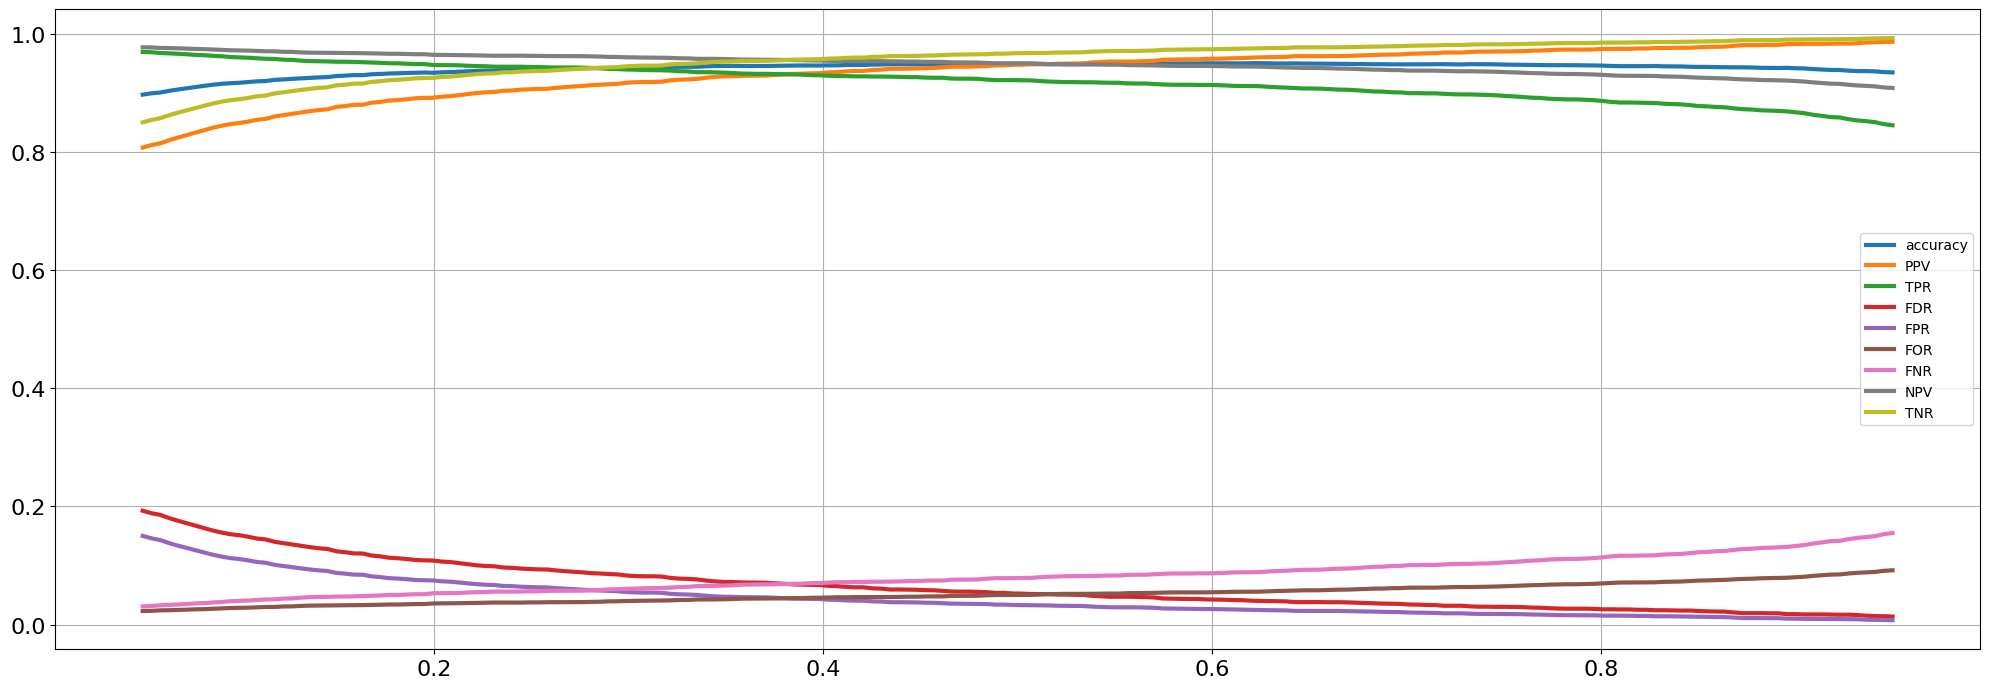

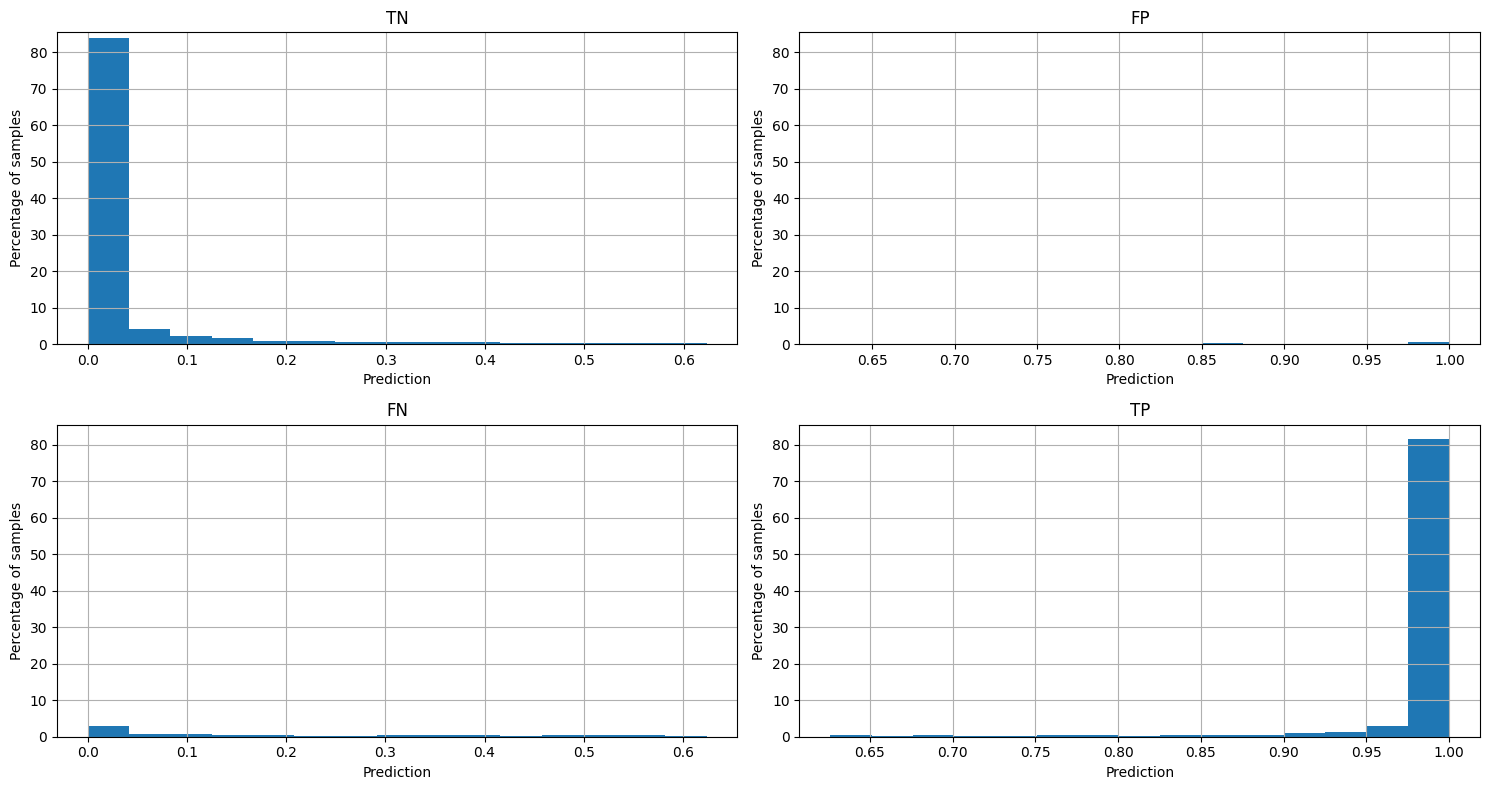

In [24]:
# Custom evaluate
best_threshold = threshold_evaluation_plotter(X_test_encoded_padded, y_test)
mean_prediction = evaluate_nn_model(X_test_encoded_padded, y_test, threshold=best_threshold)

In [25]:
# save RNN model to file
import pickle
import joblib
from keras.models import load_model

# save the model to a joblib file
joblib.dump(model, "model_biLSTM_reduced.joblib")

# save the model to a pickle file
with open('model_biLSTM_reduced.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the model using Keras native method
model.save("model_biLSTM_reduced.h5")